<a href="https://colab.research.google.com/github/VIGNESHinZONE/Beginners-level-ML-projects/blob/master/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre deepchem[jax]

     |████████████████████████████████| 609 kB 11.0 MB/s 
     |████████████████████████████████| 118 kB 52.6 MB/s 
     |████████████████████████████████| 284 kB 30.1 MB/s 
     |████████████████████████████████| 57 kB 6.0 MB/s 


In [ ]:
import numpy as np
import functools
try:
  import jax
  import jax.numpy as jnp
  import haiku as hk
  import optax
  from deepchem.models import PINNModel, JaxModel
  from deepchem.data import NumpyDataset
  from deepchem.models.optimizers import Adam
  from jax import jacrev
  has_haiku_and_optax = True
except:
  has_haiku_and_optax = False




# Given Physical Data

We have a 10 random points between $x\in [-2\pi, 2\pi]$ and its corresponding value f(x)

We know that data follows an underlying physical rule that

$\frac{df(x)}{dx} = -sin(x) $



Text(0.5, 1.0, 'Data of our physical system')

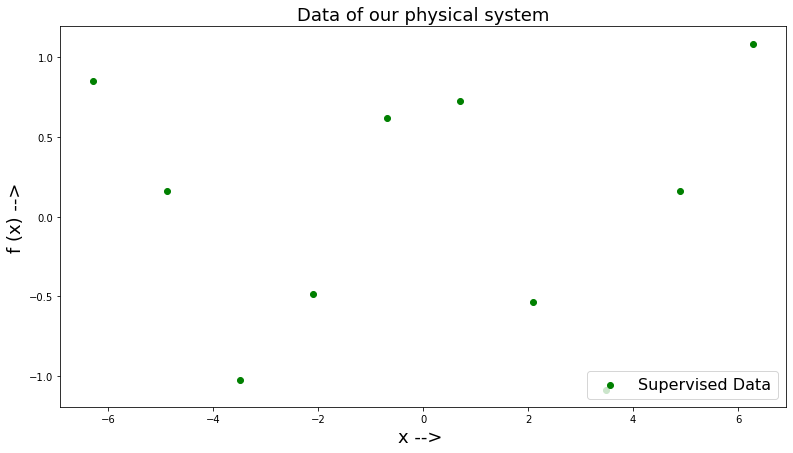

In [ ]:
import matplotlib.pyplot as plt

give_size = 10
in_given = np.linspace(-2 * np.pi, 2 * np.pi, give_size)
out_given = np.cos(in_given) + 0.1*np.random.normal(loc=0.0, scale=1, size=give_size)



# red for numpy.sin()
plt.figure(figsize=(13, 7))

plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)


From simple integeration, we can easily solve the diffrential equation and the solution will be - 

$f(x) = cos(x)$

Text(0.5, 1.0, 'Data of our physical system')

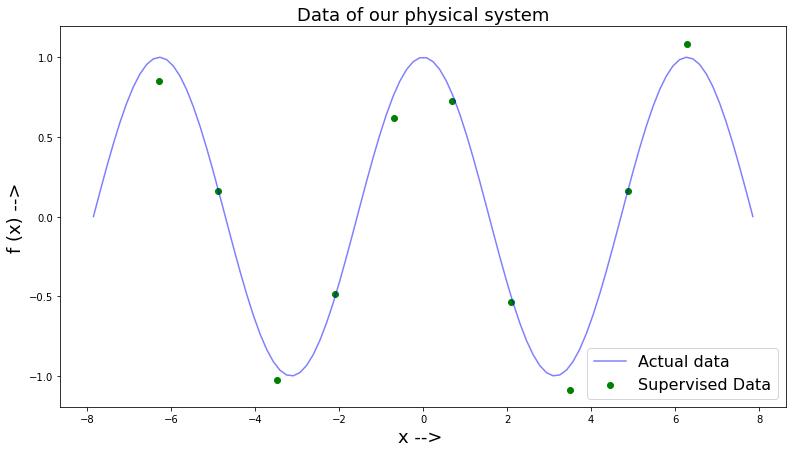

In [ ]:
import matplotlib.pyplot as plt

test = np.expand_dims(np.linspace(-2.5 * np.pi, 2.5 * np.pi, 100), 1)
out_array = np.cos(test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data" ,"Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)


# Building a Simple Neural Network Model - 

We define a simple Feed-forward Neural Network with 2 hidden layers of size 256 & 128 neurons.

In [ ]:
# defining the Haiku model

# A neural network is defined as a function of its weights & operations.
# NN(x) = F(x, W) 

# forward function defines the F which describes the mathematical operations like Matrix & dot products, Signmoid functions, etc
# W is the init_params

def f(x):
  net = hk.nets.MLP(output_sizes=[256, 128, 1], activation=jax.nn.softplus)
  val = net(x)
  return val

init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(500)
params = init_params(rng, np.random.rand(1000, 1))


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3634: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


# Fitting a simple Neural Network solution to the Physical Data

In [ ]:

train_dataset = NumpyDataset(np.expand_dims(in_given, axis=1), np.expand_dims(out_given, axis=1))
rms_loss = lambda pred, tar, w: jnp.mean(optax.l2_loss(pred, tar))
# JaxModel Working
nn_model = JaxModel(
    forward_fn,
    params,
    rms_loss,
    batch_size=100,
    learning_rate=0.001,
    log_frequency=2)
nn_model.fit(train_dataset, nb_epochs=10000, deterministic=True)



/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/jax_model.py:160: UserWarning: JaxModel is still in active development and all features may not yet be implemented
  'JaxModel is still in active development and all features may not yet be implemented'


2.1729056921826473e-11

Text(0.5, 1.0, 'Data of our physical system')

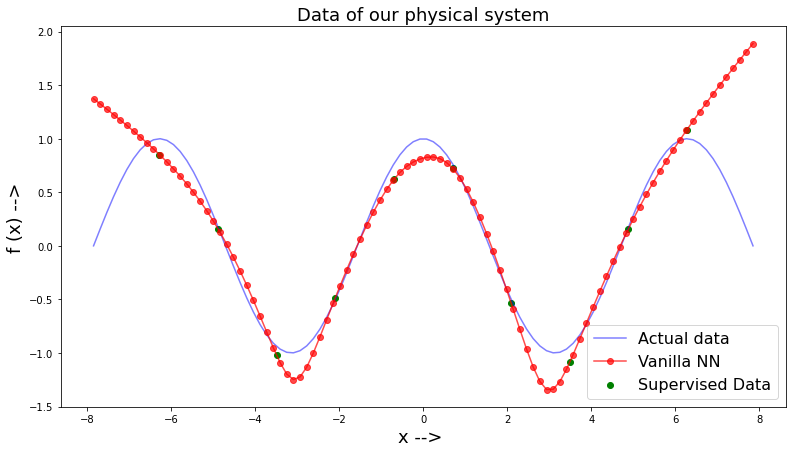

In [ ]:
dataset_test = NumpyDataset(test)
nn_output = nn_model.predict(dataset_test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.plot(test, nn_output, color = 'red', marker = "o", alpha = 0.7)
plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data", "Vanilla NN", "Supervised Data"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)

# Learning to fit the Data using the underlying Diffrential equation

Lets ensure that final output of the neural network satisfies the diffrential equation as a loss function- 

In [ ]:
def create_eval_fn(forward_fn, params):
  """
    Calls the function to evaluate the model
  """

  @jax.jit
  def eval_model(x, rng=None):

    bu = forward_fn(params, rng, x)
    return jnp.squeeze(bu)

  return eval_model

def gradient_fn(forward_fn, loss_outputs, initial_data):
  """
  This function calls the gradient function, to implement the backpropagation
  """
  boundary_data = initial_data['X0']
  boundary_target = initial_data['u0']

  @jax.jit
  def model_loss(params, target, weights, rng, x_train):

    @functools.partial(jax.vmap, in_axes=(None, 0))
    def periodic_loss(params, x):
      """
      diffrential equation => grad(f(x)) = - sin(x)
      minimize f(x) := grad(f(x)) + sin(x)
      """
      x = jnp.expand_dims(x, 0)
      u_x = jacrev(forward_fn, argnums=(2))(params, rng, x)
      return u_x + jnp.sin(x)

    u_pred = forward_fn(params, rng, boundary_data)
    loss_u = jnp.mean((u_pred - boundary_target)**2)

    f_pred = periodic_loss(params, x_train)
    loss_f = jnp.mean((f_pred**2))

    return loss_u + loss_f

  return model_loss


In [ ]:



initial_data = {
    'X0': jnp.expand_dims(in_given, 1),
    'u0': jnp.expand_dims(out_given, 1)
}
opt = Adam(learning_rate=1e-3)
pinn_model= PINNModel(
    forward_fn=forward_fn,
    params=params,
    initial_data=initial_data,
    batch_size=1000,
    optimizer=opt,
    grad_fn=gradient_fn,
    eval_fn=create_eval_fn,
    deterministic=True,
    log_frequency=1000)

# defining our training data. We feed 100 points between [-2.5pi, 2.5pi] without the labels,
# which will be used as the differential loss(regulariser)
X_f = np.expand_dims(np.linspace(-3 * np.pi, 3 * np.pi, 1000), 1)
dataset = NumpyDataset(X_f)
pinn_model.fit(dataset, nb_epochs=3000)


/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/pinns_model.py:157: UserWarning: PinnModel is still in active development and we could change the design of the API in the future.
  'PinnModel is still in active development and we could change the design of the API in the future.'
/usr/local/lib/python3.7/dist-packages/deepchem/models/jax_models/jax_model.py:160: UserWarning: JaxModel is still in active development and all features may not yet be implemented
  'JaxModel is still in active development and all features may not yet be implemented'


0.026332732232287527

Text(0.5, 1.0, 'Data of our physical system')

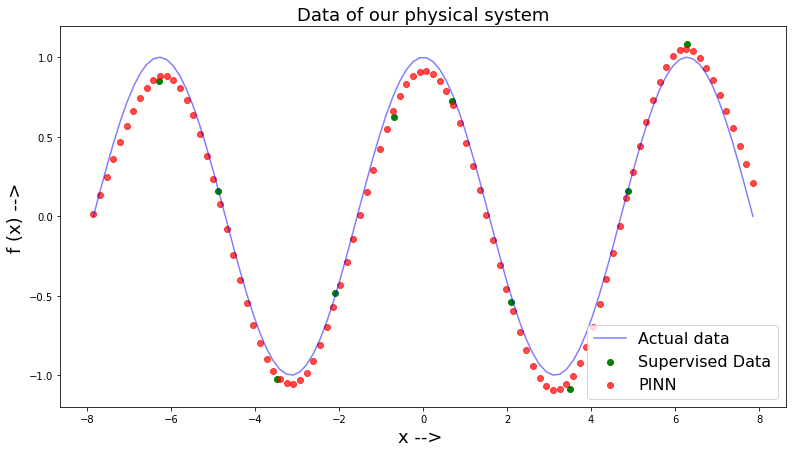

In [ ]:
import matplotlib.pyplot as plt

pinn_output = pinn_model.predict(dataset_test)

plt.figure(figsize=(13, 7))
plt.plot(test, out_array, color = 'blue', alpha = 0.5)
plt.scatter(in_given, out_given, color = 'green', marker = "o")
# plt.plot(test, nn_output, color = 'red', marker = "x", alpha = 0.3)
plt.scatter(test, pinn_output, color = 'red', marker = "o", alpha = 0.7)

plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Actual data" ,"Supervised Data", "PINN"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)

# Comparing the results between PINN & Vanilla NN model

Text(0.5, 1.0, 'Data of our physical system')

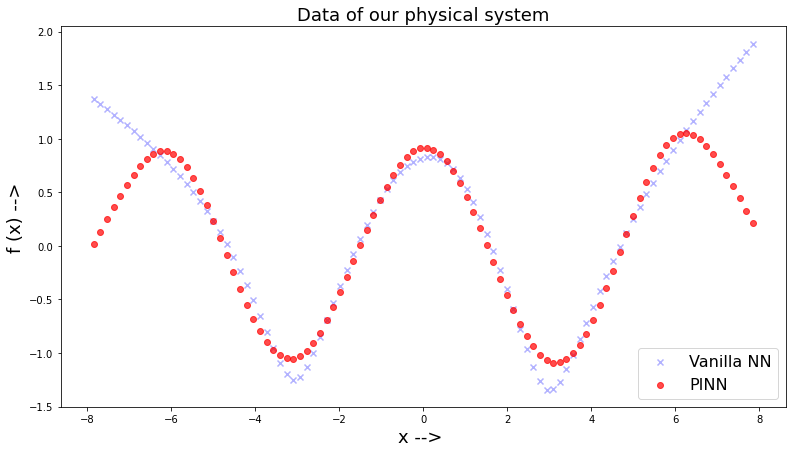

In [ ]:

plt.figure(figsize=(13, 7))
# plt.plot(test, out_array, color = 'blue', alpha = 0.5)
# plt.scatter(in_given, out_given, color = 'green', marker = "o")
plt.scatter(test, nn_output, color = 'blue', marker = "x", alpha = 0.3)
plt.scatter(test, pinn_output, color = 'red', marker = "o", alpha = 0.7)

plt.xlabel("x --> ", fontsize=18)
plt.ylabel("f (x) -->", fontsize=18)
plt.legend(["Vanilla NN", "PINN"], prop={'size': 16}, loc ="lower right")

plt.title("Data of our physical system", fontsize=18)